In [37]:
pip install -U "transformers>=4.48.0" "peft>=0.14.0" "accelerate>=1.1.0" "bitsandbytes>=0.45.0" "datasets"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


# 1. Library

In [38]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [39]:
import os
import torch
import numpy as np
import json
import pandas as pd

import warnings
from pydantic import PydanticDeprecatedSince20
warnings.filterwarnings("ignore", category=UserWarning)

from datasets import load_dataset, DatasetDict
from transformers.trainer_utils import get_last_checkpoint
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from pathlib import Path

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    TrainerCallback,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)

# 2. Load dataset

In [40]:
ds = load_dataset("bkai-foundation-models/vi-alpaca")

In [41]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 50006
    })
})


In [42]:
ds = ds['train']

## View dataset

In [43]:
ds.to_pandas().head()

,instruction,input,output
0,Hãy viết một bài blog ngắn về lợi ích của việc...,Tiêu đề: Lợi ích của việc đọc sách\nMô tả: Bài...,Bài viết: \nViệc đọc sách có rất nhiều lợi ích...
1,Tạo ra một danh sách từ vựng tiếng Anh có chủ ...,"Tiếng Anh, Toán học, Vật lý, Hóa học, Sinh học...",Danh sách từ vựng tiếng Anh với chủ đề các môn...
2,Hãy cung cấp một hướng dẫn để tạo một trình ch...,Trình chỉnh sửa video miễn phí,Hướng dẫn tạo một trình chỉnh sửa video đơn gi...
3,Chỉ ra một khả năng tích cực của người ít được...,Người bạn đề cập đến thường ít nói nhưng khi n...,"Dù ít nói, người đó thường mang lại những ý ki..."
4,Viết một hướng dẫn về cách tạo một trò chơi đơ...,"Hãy tạo một trò chơi đố vui đơn giản, nơi ngườ...",Dưới đây là một hướng dẫn về cách tạo một trò ...


In [44]:
ds.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50006 entries, 0 to 50005
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  50006 non-null  object
 1   input        50006 non-null  object
 2   output       50006 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## Downsampling dataset

In [45]:
# 1) Shuffle để ngẫu nhiên
ds_shuffle = ds.shuffle(seed=42)

# 2) Chọn 14k mẫu đầu
ds_small = ds_shuffle.select(range(14000))

print(ds_small)

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 14000
})


In [46]:
# 10k train
train_ds = ds_small.select(range(0, 10000))

# 4k remain
temp_ds = ds_small.select(range(10_000, 14_000))

#2k val
val_ds = temp_ds.select(range(0, 2_000))

# 2k test
test_ds = temp_ds.select(range(2_000, 4_000))

print(len(train_ds), len(val_ds), len(test_ds))

10000 2000 2000


## View train

In [47]:
train_ds.to_pandas().head()

,instruction,input,output
0,Cung cấp một phần của một bài viết hoặc một đo...,"""Trang trại là nơi nuôi dưỡng và chăm sóc""","""trồng cây trồng rau, nuôi các loại động vật c..."
1,Viết một câu hướng dẫn cho việc tạo một bài vi...,,Hướng dẫn: Hãy viết một bài viết ngắn (khoảng ...
2,Phân loại các từ trong đoạn văn sau thành danh...,"""Con mèo nhỏ và đáng yêu đang nằm êm trong chi...","- Danh từ: con mèo, giỏ\n- Động từ: nằm\n- Tín..."
3,Dẫn dắt người đọc để tạo một món ăn đơn giản n...,Bạn muốn nấu một món ăn ngon nhưng đơn giản? H...,Bạn muốn nấu một món ăn ngon nhưng đơn giản? H...
4,Hãy viết một bức thư tạm biệt ngắn (khoảng 50-...,,"Chào [tên bạn],\n\nTôi viết thư này để nói lời..."


In [48]:
train_ds.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  10000 non-null  object
 1   input        10000 non-null  object
 2   output       10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


## View val

In [49]:
val_ds.to_pandas().head()


,instruction,input,output
0,Viết một hàm SQL để lấy danh sách tất cả các k...,"Bảng ""Customers"":\n| id | name | address ...",SELECT * FROM Customers WHERE address = 'Hà Nội';
1,Hãy giúp viết một lời chúc sinh nhật ngắn và t...,Chúc mừng sinh nhật em! Chúc em có một ngày đá...,"""Chúc mừng sinh nhật em! Tôi hy vọng những điề..."
2,Tìm hiểu về một cuộc thi thể thao quốc tế nổi ...,World Cup (World Cup bóng đá),World Cup là một cuộc thi bóng đá quốc tế được...
3,Tìm một hình ảnh về cây hoa anh đào và mô tả v...,,Đây là hình ảnh về cây hoa anh đào. Hoa anh đà...
4,Viết một đoạn văn ngắn (khoảng 3-4 câu) mô tả ...,,"Nằm ở miền Trung Việt Nam, Hội An là một thành..."


In [50]:
val_ds.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  2000 non-null   object
 1   input        2000 non-null   object
 2   output       2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


## View test

In [51]:
test_ds.to_pandas().head()

,instruction,input,output
0,Chỉ ra các bước cần thiết để thực hiện một cuộ...,,Để thực hiện một cuộc gọi điện thoại trực tuyế...
1,Xác định nguyên nhân gây lỗi và sửa lỗi trên t...,"Trang web của tôi hiển thị lỗi ""404 Not Found""...","Việc hiển thị lỗi ""404 Not Found"" có thể có nh..."
2,Thêm một số vừa ý nhím tại nơi chăn thả bảo tồ...,,Để thêm một số vừa ý nhím tại nơi chăn thả bảo...
3,Bạn đang ở TPHCM và muốn tìm một nhà hàng ngon...,Tôi đang ở TPHCM và muốn tìm một nhà hàng tốt ...,Xin chào! Dưới đây là một số nhà hàng phù hợp ...
4,"Cho một danh sách các từ, hãy đếm số từ có độ ...","Danh sách: [""apple"", ""banana"", ""cherry"", ""oran...",Số từ có độ dài lớn hơn 5 trong danh sách là 2.


In [52]:
test_ds.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  2000 non-null   object
 1   input        2000 non-null   object
 2   output       2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


# 3. Load model & tokenizer

In [53]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", use_fast=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-1.5B-Instruct", 
    quantization_config=bnb_config,
    device_map="auto",
)

model.config.use_cache = False
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)

model = get_peft_model(model, lora_config)
model.enable_input_require_grads()


In [54]:
messages = [
    {"role": "user", "content": "Who are you?"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))


I am Qwen, an AI assistant created by Alibaba Cloud. I can answer questions, provide information on various topics, and engage in conversations. Is there anything specific you would like to know or discuss


# 4. Format data

In [55]:
def build_messages(ex):
    inst = ex["instruction"]
    inp  = ex["input"]
    out  = ex["output"]

    if inp and inp.strip():
        user_content = (
            f"### HƯỚNG DẪN:\n{inst}\n\n"
            f"### ĐẦU VÀO:\n{inp}"
        )
    else:
        user_content = f"### HƯỚNG DẪN:\n{inst}"

    messages = [
        {"role": "system", "content": "Bạn là trợ lý AI hiểu tiếng Việt và trả lời ngắn gọn, rõ ràng."},
        {"role": "user", "content": user_content},
        {"role": "assistant", "content": out},
    ]
    return {"messages": messages}

In [56]:
train_ds = train_ds.map(build_messages, remove_columns=train_ds.column_names)
val_ds = val_ds.map(build_messages, remove_columns=val_ds.column_names)
test_ds = test_ds.map(build_messages, remove_columns=test_ds.column_names)

In [57]:
train_ds.to_pandas().head()

,messages
0,[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt...
1,[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt...
2,[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt...
3,[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt...
4,[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt...


In [58]:
def count_tokens(example):
    # Dùng cùng chat template như khi train
    text = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,           # trả về string
        add_generation_prompt=False,
    )

    ids = tokenizer(
        text,
        add_special_tokens=True,
        padding=False,
        truncation=False,         # KHÔNG cắt, để biết độ dài thật
    )["input_ids"]

    return {"n_tokens": len(ids)}


train_with_len = train_ds.map(
    count_tokens,
    desc="Đếm số token của train_ds",
)

lengths = train_with_len["n_tokens"]

print("Số mẫu train:", len(lengths))
print("Token min   :", min(lengths))
print("Token max   :", max(lengths))
print("Token mean  :", sum(lengths) / len(lengths))

percentiles = [50, 75, 90, 95, 99]
values = np.percentile(lengths, percentiles)

for p, v in zip(percentiles, values):
    print(f"{p}th percentile: {int(v)} tokens")


Số mẫu train: 10000
Token min   : 54
Token max   : 1735
Token mean  : 274.8111
50th percentile: 231 tokens
75th percentile: 383 tokens
90th percentile: 513 tokens
95th percentile: 586 tokens
99th percentile: 727 tokens


# 5. Tokenize train/val/test

In [59]:
MAX_LEN = 256

def tokenize_for_training(batch):
    texts = []
    for msgs in batch["messages"]:
        text = tokenizer.apply_chat_template(
            msgs,
            tokenize=False,
            add_generation_prompt=False,   # mình đã có assistant reply trong messages
        )
        texts.append(text)

    enc = tokenizer(
        texts,
        max_length=MAX_LEN,
        truncation=True,
        padding=False,
    )

    enc["labels"] = enc["input_ids"].copy()
    return enc

train_tok = train_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=train_ds.column_names,
    desc="Tokenize train",
)

val_tok = val_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=val_ds.column_names,
    desc="Tokenize val",
)

test_tok = test_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=test_ds.column_names,
    desc="Tokenize test",
)


Tokenize val:   0%|          | 0/2000 [00:00<?, ? examples/s]

# 6. Training

In [60]:
# DataCollator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,   # causal LM
)


In [61]:
# EarlyStoping

class MyEarlyStoppingCallback(EarlyStoppingCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Chỉ in ở process chính (tránh in lặp lại trong multi-GPU)
        if state.is_world_process_zero:
            print("✅ Training dừng sớm bởi EarlyStoppingCallback")
            print(f"  - Global step: {state.global_step}")
            print(f"  - Best metric: {state.best_metric}")
            print(f"  - Best model checkpoint: {state.best_model_checkpoint}")
        # Gọi lại hàm gốc để không phá logic early stopping
        return super().on_train_end(args, state, control, **kwargs)


In [62]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/qwen25-1_5b-vi-alpaca-small",
    num_train_epochs=5,                # thử 1 epoch trước, sau đó tăng lên 2–3 nếu ổn
    per_device_train_batch_size=1,     # full finetune -> để 1 cho chắc
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,     # 1*8 = effective batch 8
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    optim="paged_adamw_8bit",
    load_best_model_at_end=True,     # sau khi train xong, load lại model tốt nhất
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    fp16=True,                         # Kaggle dùng fp16
    bf16=False,

    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",                  # tắt WandB nếu không dùng

    label_names=["labels"],
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    callbacks=[
        MyEarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.036, 
        )
    ],
)

In [63]:
output_dir = training_args.output_dir
last_ckpt = get_last_checkpoint(output_dir)

if last_ckpt is not None:
    print(f"Found last checkpoint: {last_ckpt}")

    # Đọc trạng thái trainer từ checkpoint
    state_path = os.path.join(last_ckpt, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    last_epoch = state.get("epoch", None)
    global_step = state.get("global_step", None)

    print(f"Lần trước dừng ở epoch: {last_epoch}")
    print(f"Global step: {global_step}")

    # Tiếp tục train từ checkpoint này
    print("Trainer device:", trainer.args.device)
    trainer.train(resume_from_checkpoint=last_ckpt)
    
else:
    print("Không tìm thấy checkpoint, train từ đầu.")
    print("Trainer device:", trainer.args.device)
    trainer.train()



Found last checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-3750
Lần trước dừng ở epoch: 3.0
Global step: 3750
Trainer device: cuda:0


Epoch,Training Loss,Validation Loss
4,0.422400,0.960923
5,0.270000,1.080247


✅ Training dừng sớm bởi EarlyStoppingCallback
  - Global step: 6250
  - Best metric: 0.8291677236557007
  - Best model checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-1250


In [64]:
output_dir = training_args.output_dir
last_ckpt = Path(get_last_checkpoint(output_dir))
state_path = last_ckpt / "trainer_state.json"
    
# 1) Đọc trainer_state.json
with open(state_path, "r", encoding="utf-8") as f:
    state = json.load(f)


# 2) Lấy log_history -> DataFrame
logs = state["log_history"]          # list[dict]
df_logs = pd.DataFrame(logs)


# 3) Lọc các dòng có eval_loss (mỗi epoch 1 dòng)
df_eval = df_logs[df_logs["eval_loss"].notna()][["epoch", "eval_loss", "eval_runtime"]]
df_eval = df_eval.reset_index(drop=True)

print(df_eval)

   epoch  eval_loss  eval_runtime
0    1.0   0.829168      337.2751
1    2.0   0.867665      343.2578
2    3.0   0.878459      339.0116
3    4.0   0.960923      338.1896
4    5.0   1.080247      338.8519


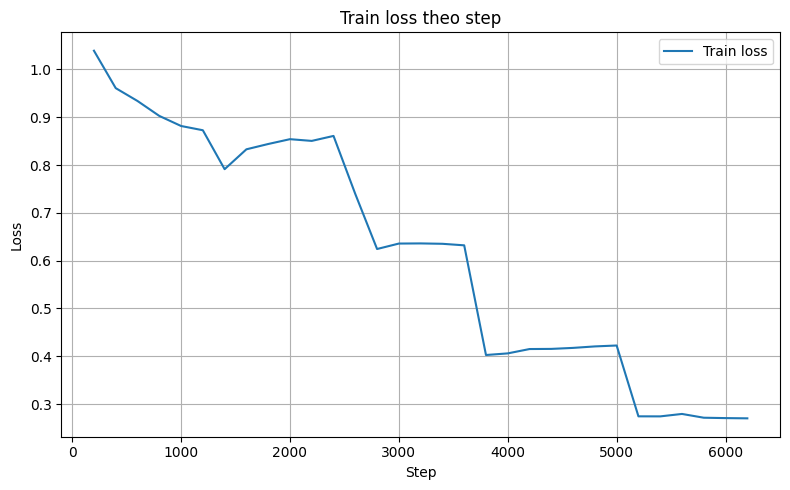

In [65]:
# Các bước có train loss
df_train = df_logs[df_logs["loss"].notna()][["step", "loss"]]

# # Các bước có eval loss
df_eval = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Đường train loss (dày hơn chút cho dễ nhìn)
plt.plot(df_train["step"], df_train["loss"], label="Train loss")


plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train loss theo step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


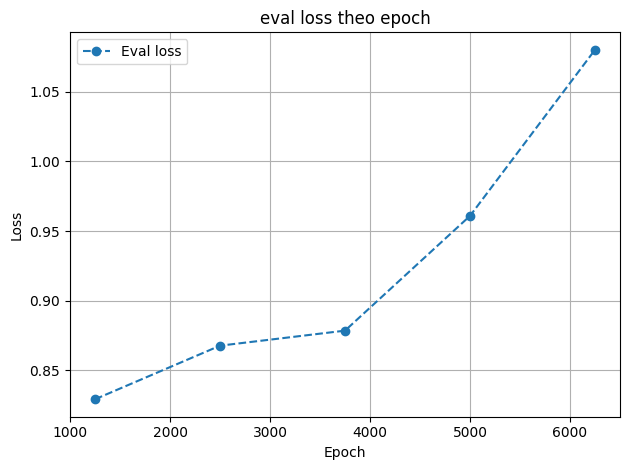

In [66]:
# # Các bước có eval loss
df_eval = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.plot(df_eval["step"], df_eval["eval_loss"], marker="o", linestyle="--", label="Eval loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("eval loss theo epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Push best model to huggingface

In [82]:
print("Best checkpoint:", trainer.state.best_model_checkpoint)

Best checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-1250


In [83]:
# take best model
best_dir = "/kaggle/working/qwen25-1_5b-vi-alpaca-small"

trainer.save_model(best_dir)        # lưu best model (weights + config)
tokenizer.save_pretrained(best_dir) # lưu tokenizer

print("Best model saved to:", best_dir)


Best model saved to: /kaggle/working/qwen25-1_5b-vi-alpaca-small


In [84]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_token")

In [85]:
from huggingface_hub import login
login(token=secret_value_0)

In [86]:
# Đặt tên repo trên Hugging Face (đổi myusername thành username HF của bạn)
repo_id = "lndat18/qwen25-1_5b-vi-alpaca-small"

# Load lại best model từ thư mục
model_to_push = AutoModelForCausalLM.from_pretrained(best_dir)
tokenizer_to_push = AutoTokenizer.from_pretrained(best_dir)

# Đẩy lên Hugging Face Hub
model_to_push.push_to_hub(repo_id)
tokenizer_to_push.push_to_hub(repo_id)

print("Pushed to HF repo:", repo_id)


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Pushed to HF repo: lndat18/qwen25-1_5b-vi-alpaca-small


## Push dataset to HuggingFace

In [72]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['messages'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 2000
    })
})


In [87]:
repo_id = "lndat18/vi-alpaca_small"  # đặt tên repo tùy bạn

dataset.push_to_hub(
    repo_id,
    private=False,  # True nếu bạn muốn dataset private
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/lndat18/vi-alpaca_small/commit/31fdeb873e983e1d80e5c6a45bfe365d550939ac', commit_message='Upload dataset', commit_description='', oid='31fdeb873e983e1d80e5c6a45bfe365d550939ac', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/lndat18/vi-alpaca_small', endpoint='https://huggingface.co', repo_type='dataset', repo_id='lndat18/vi-alpaca_small'), pr_revision=None, pr_num=None)

# 7. Evaluate by Perplexity

In [90]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

In [91]:
base_model_id = "Qwen/Qwen2.5-1.5B-Instruct"      # model gốc lúc bạn fine-tune
adapter_id    = "lndat18/qwen25-1_5b-vi-alpaca-small"  # repo LoRA của bạn

In [92]:
# 1. Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    trust_remote_code=True,
)

# 2. Gắn LoRA adapter
model = PeftModel.from_pretrained(
    base_model,
    adapter_id,
)

# 3. (tuỳ chọn) Chuyển model sang eval để suy luận
model.eval()


`torch_dtype` is deprecated! Use `dtype` instead!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(

In [93]:
ds = load_dataset("lndat18/vi-alpaca_small")

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/996k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/993k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [94]:
text = "Hãy giải thích mô hình Transformer bằng tiếng Việt."
inputs = tokenizer(text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hãy giải thích mô hình Transformer bằng tiếng Việt. Mô hình này được sử dụng trong lĩnh vực trí tuệ nhân tạo và có vai trò quan trọng trong việc xử lý ngôn ngữ tự nhiên.

Mô hình Transformer là một thuật toán học máy được phát triển bởi Google. Nó đã trở thành một công cụ quan trọng trong lĩnh vực trí tuệ nhân tạo, đặc biệt là trong xử lý ngôn ngữ tự nhiên.

Transformer được xây dựng dựa trên mô hình Gated Recurrent Unit (GRU) nhưng thay vì sử dụng các lớp lặp truyền thống như GRU, nó sử dụng một cấu trúc gọi là "tuyến thông tin" để lưu trữ
